# Interrogate crop poylgon to explore phenology

**What does this notebook do?** This notebook pulls in data for all available sensors (LS5, LS7, LS8, S2a, S2b) based on the extent of a provided polygon. The polygon is then used to mask the data, and the average NDWI is calculated for the entire polygon. The user can select a point on a scatter plot and draw the false colour image for that scene. 

**Date** May 2018

**Author** Claire Krause

**Required inputs** A shape file containing the polygon you would like to use for the analysis

In [1]:
%pylab notebook

from datacube.storage import masking
from datacube import Datacube
from datacube.utils import geometry
import fiona
import rasterio.features
import xarray as xr
import shapefile as shpf
import shapely

# Import widgets for interactive notebook
import ipywidgets as widgets

import sys
import os
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/Scripts'))
import DEADataHandling
import BandIndices

s2dc = Datacube(config='/home/156/cek156/Sentinel2_datacube.conf')
dc = Datacube(app = 'test')

Populating the interactive namespace from numpy and matplotlib


In [20]:
shape_file = '/g/data/r78/cek156/dea-notebooks/random_tasks/Summer201617/NamoiIrrigated201617Summer.shp'
MaxNDVIFile = '/g/data/r78/cek156/datacube_stats/Namoi_summer/NDVI/ndvi_None_20161101.tif'

AllSensors = ['ls5', 'ls7', 'ls8', 's2a', 's2b']

DataToInterrogate = 'fc'

In [21]:
def onclick_polygon_interrogation(event):
    global pixelx, pixely, AlldataMasked, FieldMean
    pixelx, pixely = int(event.xdata), int(event.ydata)
    # Generate a point from the location
    Clickpoint = shapely.geometry.Point(pixelx, pixely)
    IrrigatedShapes = IrrigatedPolygons.shapes()
    # Find the polygon that contains the selected point
    Clickedpolygon = []
    for ix, shapes in enumerate(IrrigatedPolygons.shapes()):
        if shapely.geometry.shape(shapes).contains(Clickpoint) == True:
            Clickedpolygon.append(ix)
    # Colour the chosen polygon on the figure
    x = [i[0] for i in IrrigatedShapes[Clickedpolygon[0]].points[:]]
    y = [i[1] for i in IrrigatedShapes[Clickedpolygon[0]].points[:]]
    
    plt.figure(fig1.number)
    plt.plot(x, y, 'r')
    
    # Grab the geometry from the polygon we want to interrogate
    with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = shapes[Clickedpolygon[0]]['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)
    
    
    if DataToInterrogate == 'nbar':
        querys2 = {'output_crs': 'EPSG:3577',
                   'resolution': (-10, 10),
                   'geopolygon': geom,
                   'time':('2016-11-01', '2017-04-30')
                  }
        queryls = {'geopolygon': geom,
                   'time':('2016-11-01', '2017-04-30')
                  }

        # dc.load the data using the polygon as the bounds
        Alldata = dict()
        for Sensor in AllSensors:
            if Sensor[0] == 'l':
                try:
                    Alldata[Sensor], LScrs, LSaffine = DEADataHandling.load_nbarx(dc, Sensor, 
                                                                                  queryls, 
                                                                                  product = 'nbar')
                except TypeError:
                    print('No data available for {}'.format(Sensor))
            if Sensor[0] == 's':
                prodname = '{0}_ard_granule'.format(Sensor)
                try:
                    Alldata[Sensor], S2crs, S2affine = DEADataHandling.load_sentinel(s2dc, 
                                                                                     prodname, 
                                                                                     querys2)
                except TypeError:
                    print('No data available for {}'.format(Sensor))
    
    elif DataToInterrogate == 'fc':
        queryfc = {'geopolygon': geom,
                   'time':('2016-11-01', '2017-04-30')}
              
        # dc.load the data using the polygon as the bounds
        Alldata = dict()
        for Sensor in AllSensors:
            try:
                Alldata[Sensor] = dc.load(product = '{}_fc_albers'.format(Sensor), 
                                          group_by='solar_day', **queryfc)
            except (TypeError, ValueError):
                print('No data available for {}'.format(Sensor))
                
    # Tidy up our dict to remove any empty keys
    for Sensor in AllSensors:
        try:
            Alldata[Sensor]
            if Alldata[Sensor] is None:
                del Alldata[Sensor]
            else:
                try:
                    Alldata[Sensor].time
                except AttributeError:
                    del Alldata[Sensor]
        except KeyError:
                pass

    # Mask the returned data with the polygon to remove any extra data
    AlldataMasked = Alldata.copy()
    for Sensor in Alldata.keys():
        mask = rasterio.features.geometry_mask([geom.to_crs(Alldata[Sensor].geobox.crs) for geoms in [geom]],
                                               out_shape=Alldata[Sensor].geobox.shape,
                                               transform=Alldata[Sensor].geobox.affine,
                                               all_touched=False,
                                               invert=True)
        AlldataMasked[Sensor] = Alldata[Sensor].where(mask)

    if DataToInterrogate == 'nbar':
        # Calculate the NDVI for each sensor
        for Sensor in AllSensors:
            try:
                AlldataMasked[Sensor]['NDVI'] = BandIndices.calculate_indices(AlldataMasked[Sensor], 'NDVI')
            except KeyError:
                pass

        # Concatenate all out 
        Allvalues = xr.concat([masked.NDVI for masked in AlldataMasked.values()], dim='time')
        Allvalues = Allvalues.sortby('time')
        Allvalues.values[Allvalues.values == -999] = np.nan
        FieldMean = Allvalues.mean(dim = ('x', 'y')).dropna(dim = 'time')
    elif DataToInterrogate == 'fc':
        Allvalues = xr.merge([data for data in AlldataMasked.values()])
        Allvalues = Allvalues.sortby('time')
        Allvalues.where(Allvalues >= 0) == np.nan
        FieldMean = Allvalues.mean(dim = ('x', 'y'))

In [13]:
IrrigatedPolygons = shpf.Reader(shape_file)
NDVIData = xr.open_rasterio(MaxNDVIFile)

<IPython.core.display.Javascript object>


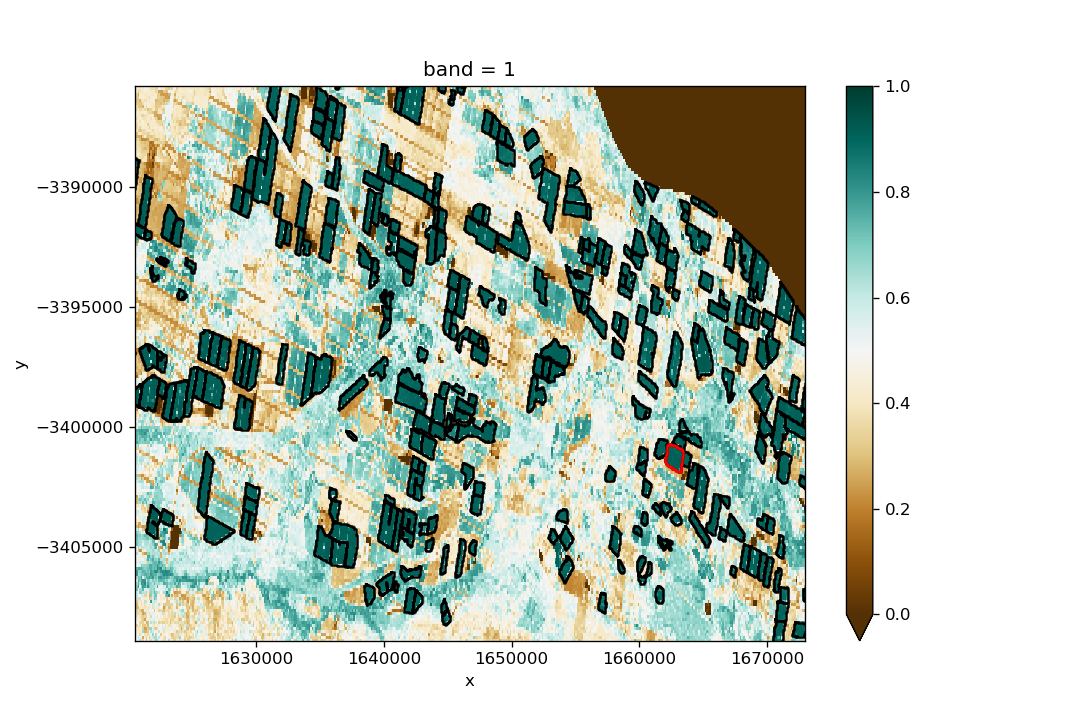

HTML(value='Click inside the polygon you would like to interrogate')

In [22]:
fig1 = plt.figure(figsize=[9, 6])

NDVIData.isel(x=range(0, len(NDVIData.x), 5),
              y=range(0, len(NDVIData.y), 5)).plot(cmap = 'BrBG', vmin=0, vmax = 1)

for shape in IrrigatedPolygons.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.show()

w = widgets.HTML("Click inside the polygon you would like to interrogate")

cid = fig1.canvas.mpl_connect('button_press_event', onclick_polygon_interrogation)
display(w)

## Plot the field phenology using each observation over the growing season

<IPython.core.display.Javascript object>


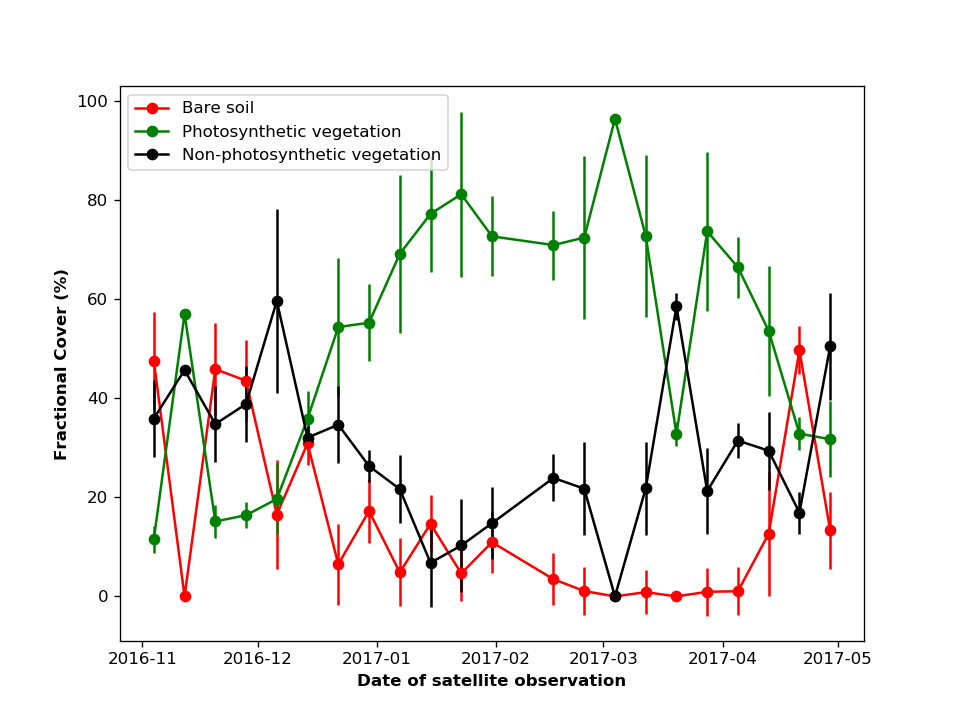

Text(0.5,0,'Date of satellite observation')

In [23]:
fig = plt.figure(figsize = [8, 6])

if DataToInterrogate == 'nbar':
    for Sensor in AllSensors:
        try:
            plt.scatter(AlldataMasked[Sensor].time.values, 
                        AlldataMasked[Sensor]['NDVI'].mean(dim = ('x', 'y')).values)
        except KeyError:
            pass
    plt.legend(AlldataMasked.keys(), loc = 'upper left')
    plt.plot(FieldMean.time, FieldMean, 'lightgrey', linestyle = '--', zorder = 0)
    plt.ylabel('Mean field NDVI', fontweight = 'bold')
else:
    plt.plot(FieldMean.time, FieldMean.BS, 'ro-')
    plt.plot(FieldMean.time, FieldMean.PV, 'go-')
    plt.plot(FieldMean.time, FieldMean.NPV, 'ko-')
    for Sensor in AllSensors:
        try:
            plt.errorbar(AlldataMasked[Sensor].time.values, AlldataMasked[Sensor].BS.mean(dim = ('x', 'y')), 
                         yerr = AlldataMasked[Sensor].BS.std(dim = ('x', 'y')), 
                         color = 'red', linestyle='none', marker='.')
            plt.errorbar(AlldataMasked[Sensor].time.values, AlldataMasked[Sensor].PV.mean(dim = ('x', 'y')), 
                         yerr = AlldataMasked[Sensor].PV.std(dim = ('x', 'y')), 
                         color = 'green', linestyle='none', marker='.')
            plt.errorbar(AlldataMasked[Sensor].time.values, AlldataMasked[Sensor].NPV.mean(dim = ('x', 'y')), 
                         yerr = AlldataMasked[Sensor].NPV.std(dim = ('x', 'y')), 
                         color = 'black', linestyle='none', marker='.')
        except KeyError:
            pass
    plt.ylabel('Fractional Cover (%)', fontweight = 'bold')
    plt.legend(['Bare soil', 'Photosynthetic vegetation', 'Non-photosynthetic vegetation'], loc = 'upper left')
    
plt.xlabel('Date of satellite observation', fontweight = 'bold')